In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = yf.download("2330.TW", start="2010-01-01", end=None, interval="1d")
data.columns = ['_'.join(col).strip() for col in data.columns.to_flat_index()]
orig_dates = data.index.copy()
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col!=series_col] + ['is_weekend']
data = data.asfreq("D").ffill()
data = data.sort_index()
data.loc[~data.index.isin(orig_dates), "Volume_2330.TW"] = 0
data['is_weekend'] = data.index.weekday >= 5


C:\Users\user\AppData\Local\Temp\ipykernel_22624\1892013540.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("2330.TW", start="2010-01-01", end=None, interval="1d")
[*********************100%***********************]  1 of 1 completed


Check log return to see trend, volatility clusters, and whether returns look stationary.

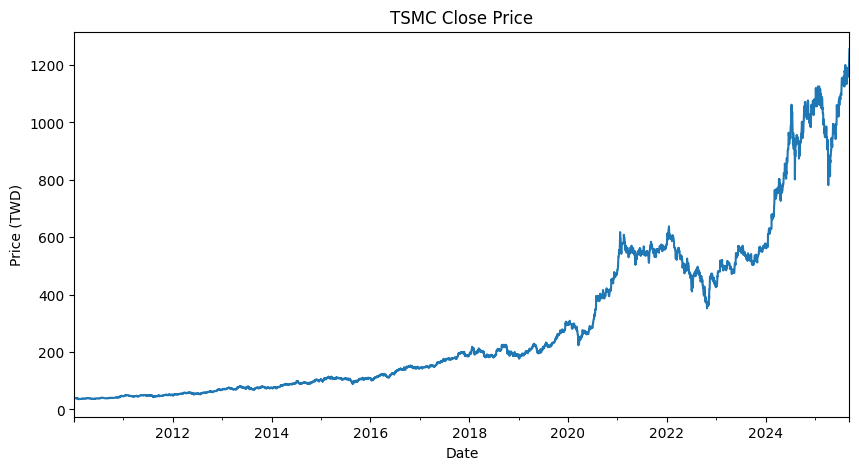

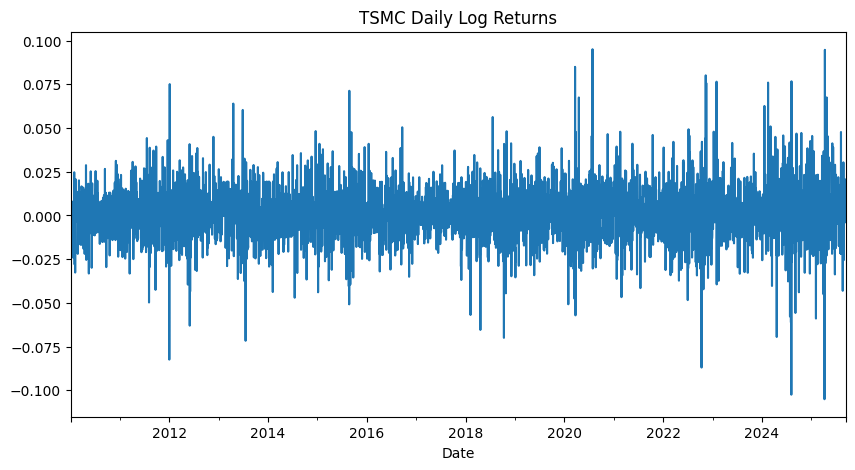

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
data[series_col].plot(ax=ax)
ax.set_title("TSMC Close Price")
ax.set_ylabel("Price (TWD)")
plt.show()

# Daily log returns
data['log_return'] = np.log(data[series_col]).diff()
data['log_return'].plot(figsize=(10,5), title="TSMC Daily Log Returns")
plt.show()

Check autocorrelation characteristics of the columns

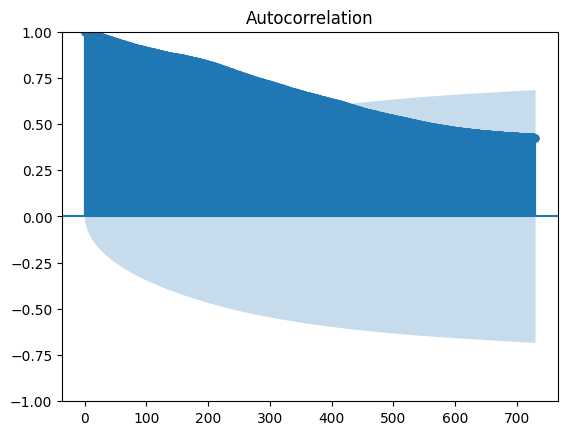

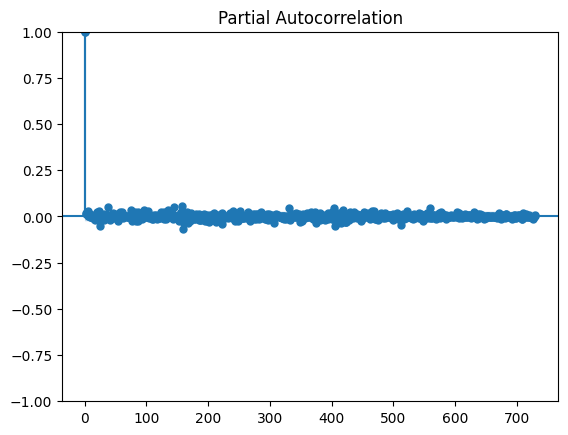

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data[series_col].dropna(), lags=730)
plt.show()
plot_pacf(data[series_col].dropna(), lags=730)
plt.show()